<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/TheNorthFace_logo.svg" alt="THE NORTH FACE LOGO" width="50%" />

# The North Face e-commerce : boosting online sales !

## Company's Description 📇

The North Face is an American outdoor recreation product company, founded in 1968 to supply climbers. The North Face produces clothing, footwear, and outdoor equipment. By the late 1990s customers had expanded beyond outdoor enthusiasts and in the 2000s it became a fashion style symbol.


## Project 🚧

The marketing department would like to take advantage of machine learning solutions to boost online sales on the website : https://www.thenorthface.fr/

They have identified two major solutions that could have a huge effect on the conversion rates :
- Deploying a **recommender system** that will allow to suggest additionnal products to users, that are similar to the items they are already interested in. The recommendations could be materialized by a "you might also be interested by these products..." section that would appear on each product page of the website.
- Improving the structure of the products catalog thanks to **topic extraction**. The idea is to use unsupervised methods to challenge the existing categories : is it possible to find new categories of product that would be more suitable for the navigation on the website ?

## Goals 🎯

The project can be cut into three steps :

1. Identify groups of products that have similar descriptions.

2. Use the groups of similar products to build a simple recommender system algorithm.

3. Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

## Scope of this project 🖼️

In this project, you'll work with a corpus of item descriptions from The North Face's product catalog. Data can be found here: 

👉👉<a href="https://www.kaggle.com/cclark/product-item-data?select=sample-data.csv" target="_blank"> The North Face product catalog</a> 👈👈


## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Preprocessing of textual data

- First, you'll have to make some preprocessings to clean the corpus (in particular, don't forget to handle stop words and to lemmatize the documents). For this step, you'll need `pandas` and `spacy`.

- Then, you can to encode the texts with **TF-IDF transformation** (this can be done with scikit learn's `TFIDFVectorizer`)

### Part 1 : Groups of products with similar descriptions

For this part, you'll have to train a **clustering model** that will create groups of products for which the descriptions are "close" to each other. 
- You can use `DBSCAN` to make some clustering on the TF-IDF matrix. When dealing with texts, the distance metric to be used is "cosine" instead of "euclidean". You have to find some values for `eps` and `min_samples` that allow to get 10-20 clusters and not too many outliers.
- You can display a `wordcloud` for each cluster to analyze the results and see if the groups contain different words.

### Part 2 - Recommender system

Then, you can use the cluster ids from part 1 to build a **recommender system**. The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we will consider that products belonging to the same cluster are similar.

- Create a function named `find_similar_items` that takes an argument `item_id` representing the id of a product, and that returns a list of 5 item ids that belong to the same cluster as the product passed in argument
- Use python's `input()` function to allow the user to choose a product and perform some suggestions of similar items

### Part 3 : Topic modeling

*This part is independant from the two others.*

The aim is to use an LSA model to automatically extract latent topics in the products' descriptions.

- Use TruncatedSVD to make some topic extraction from the TF-IDF matrix. You can try values for `n_components` that allow to get 10-20 topics. Save the encoded matrix into a variable named `topic_encoded_df`.
- Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, consider extracting the main topic of each document.
- As in part 1, you can display `wordclouds` to analyze the results.

## Deliverable 📬

To complete this project, your team should: 

- Train at least one **clustering model** on the corpus and display wordclouds describing the clusters
- Develop a simple python code that allows a user to type the id of a product he's interested in, and then get a list of similar items
- Train at least one **TruncatedSVD model** on the corpus and display wordclouds describing the latent topics


In [1]:
# Data manipulation and viz
import pandas as pd , numpy as np
import matplotlib.pyplot as plt , seaborn as sns
from wordcloud import WordCloud , STOPWORDS
from collections import Counter


# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer , PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from num2words import num2words


# Modeling
from sklearn.cluster import DBSCAN 
from sklearn.decomposition import PCA , TruncatedSVD

np.random.seed(123)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('sample-data.csv' , index_col='id')
df.head()

,description
id,
1,Active classic boxers - There's a reason why o...
2,Active sport boxer briefs - Skinning up Glory ...
3,Active sport briefs - These superbreathable no...
4,"Alpine guide pants - Skin in, climb ice, switc..."
5,"Alpine wind jkt - On high ridges, steep ice an..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  500 non-null    object
dtypes: object(1)
memory usage: 7.8+ KB


In [4]:
mean_len = np.mean([len(desc.split()) for desc in df['description']])
print('Mean lenght of the descriptions in the dataframe : ' , int(mean_len) , 'characters.')

Mean lenght of the descriptions in the dataframe :  148 characters.


## Cleaning and preproccessing

In [5]:
def clean_text(text : str):


    # Did not turned out useful
    '''# Turn the number into features
    new_string = ''
    for word in text.split():
        try:
            new_string += num2words(word)
            new_string += ' '
        except:
            if len(word) > 2:
                new_string += word 
                new_string += ' '
                 
    text = new_string.strip() '''
        



    # Remove html balises
    remove_html = re.compile('<.*?>')
    text = re.sub(remove_html, '', text)
    

    # Remove special characters, punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Lower case
    text = text.lower()
    
    # Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Stemmatisation seemed to work better
    '''# Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())'''

    # Stemmatisation
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())

    return text

test_string = 'loved love know known true trues zip zipper zipped ship shipped <dont display>'

clean_text(test_string) # Test the function

'love love know known true true zip zipper zip ship ship'

In [6]:
vectorizer = TfidfVectorizer(max_df=0.8 , min_df=0.1 , max_features=150) # Vectorize
df_copy = df.copy()
df['description'] = df['description'].apply(clean_text) # Clean the texts
matrix = vectorizer.fit_transform(df['description'])

ml_df = pd.DataFrame(matrix.toarray() , columns=vectorizer.get_feature_names_out())
ml_df.head()

,adjust,allow,allrecycl,back,blend,breathabl,brush,button,chafe,chest,...,waist,waistband,water,way,wick,wide,wont,yarn,zip,zipper
0,0.000000,0.000000,0.125687,0.217155,0.000000,0.121042,0.314206,0.0,0.000000,0.000000,...,0.000000,0.276304,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.115998,0.000000,0.0,0.279995,0.000000,...,0.000000,0.132395,0.000000,0.000000,0.123061,0.0,0.152973,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.132456,0.000000,0.000000,0.0,0.000000,0.000000,...,0.153952,0.000000,0.000000,0.000000,0.135327,0.0,0.168221,0.0,0.0,0.000000
3,0.084512,0.000000,0.000000,0.259101,0.000000,0.144423,0.187450,0.0,0.000000,0.000000,...,0.000000,0.082419,0.126968,0.194719,0.000000,0.0,0.095230,0.0,0.0,0.380905
4,0.000000,0.082438,0.065261,0.000000,0.000000,0.188546,0.244718,0.0,0.000000,0.081573,...,0.000000,0.000000,0.165759,0.000000,0.133351,0.0,0.000000,0.0,0.0,0.221011


In [7]:
# Sanity check
for word in ml_df.columns:
    if len(word) >= 10:
        print(word)

to_remove = ["phthalatefreefabr"]

lightweight
nexttoskin
phthalatefreefabr
programdetail
programweight
screenprint


In [8]:
# Sanity check 2
for word in ml_df.columns:
    #print(word)
    pass

to_remove += ['highli'   , 'wont']
ml_df = ml_df.drop(to_remove , axis=1)

## Clustering

In [9]:
def check_results_DBSCAN(labels):

    # Check the clustering results 
    print( 'Number of elements that are not considered noise by DBSCAN : '  , len(np.where((labels != -1))[0]))
    print('Number of clusters : ' , len(np.unique(labels)))
    print('Silhouette score : ' , silhouette_score(ml_df , labels , metric='cosine'))

model = DBSCAN(metric='cosine' , eps=0.15 , min_samples=10) # Very bad
model.fit(ml_df)
check_results_DBSCAN(model.labels_)

Number of elements that are not considered noise by DBSCAN :  63
Number of clusters :  3
Silhouette score :  0.06643710662969962


In [10]:
# Let's try reducing the dimentionality with PCA 
df_pca = PCA(n_components=10).fit_transform(ml_df)

model = DBSCAN(metric='cosine' , eps=0.175 , min_samples=10) # That's better ! 
model.fit(df_pca)
check_results_DBSCAN(model.labels_)

Number of elements that are not considered noise by DBSCAN :  451
Number of clusters :  9
Silhouette score :  0.1905669112892369


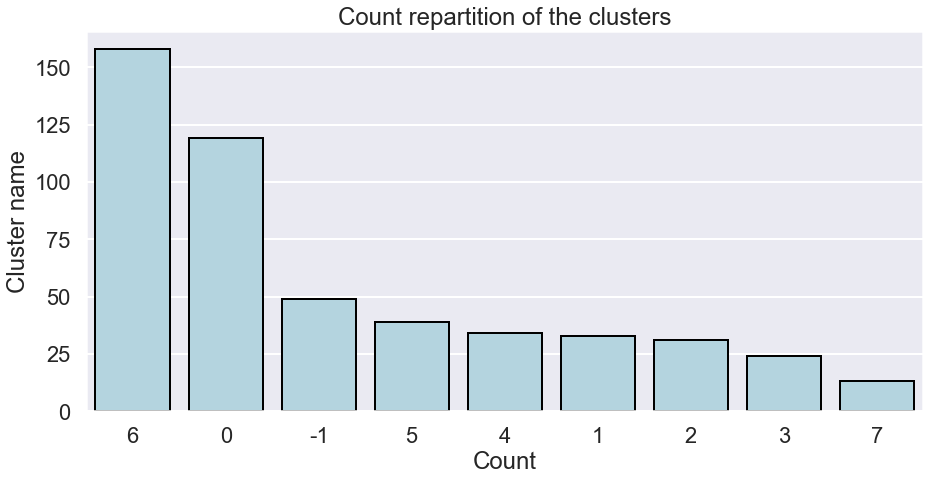

In [11]:
# Visualise the magnitude of each cluster
s = pd.Series(model.labels_)
s = dict(s.value_counts(sort=True, ascending=False))


sns.set_style('darkgrid')
sns.set_context('talk')
with sns.plotting_context('poster'):
    plt.figure(figsize=(15,7))
    sns.barplot(x=list(s.keys()) , y=list(s.values()) , order=list(s.keys()) , color='lightblue' , edgecolor='black') 
    plt.ylabel('Cluster name')
    plt.xlabel('Count')
    plt.title('Count repartition of the clusters')
    plt.show()

# Wordclouds

############### Cluster 5 ###############


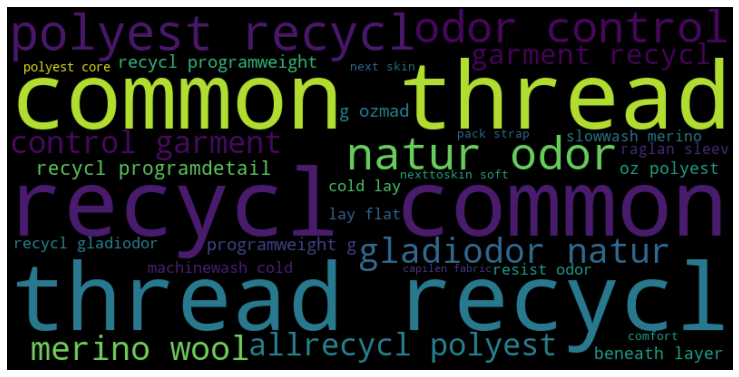




############### Cluster 0 ###############


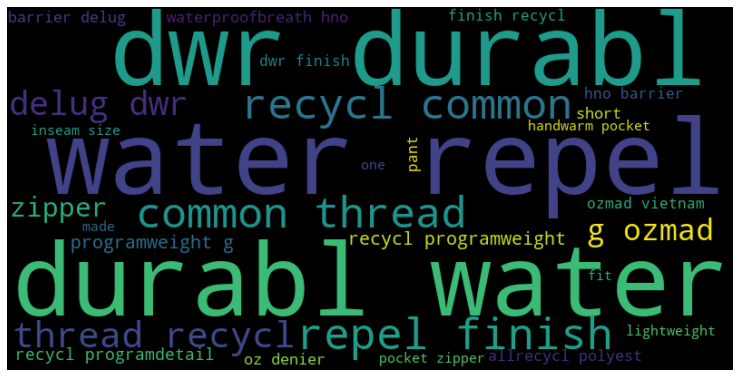




############### Cluster 1 ###############


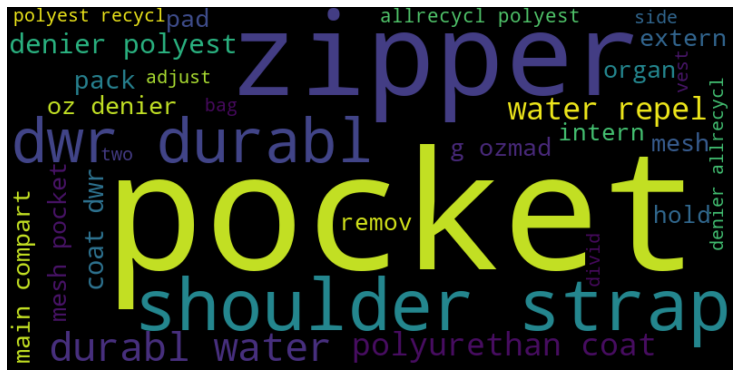




############### Cluster 2 ###############


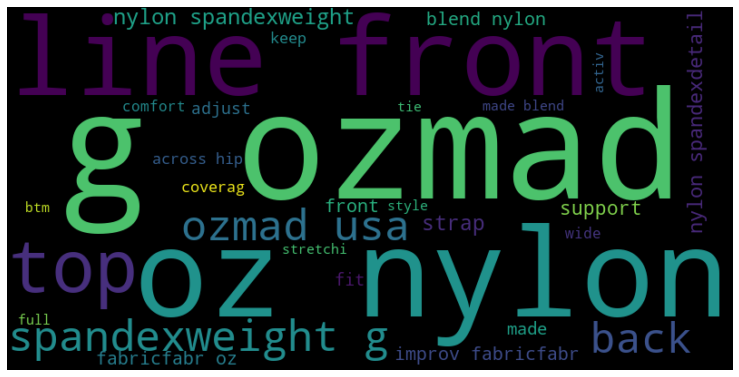




############### Cluster 3 ###############


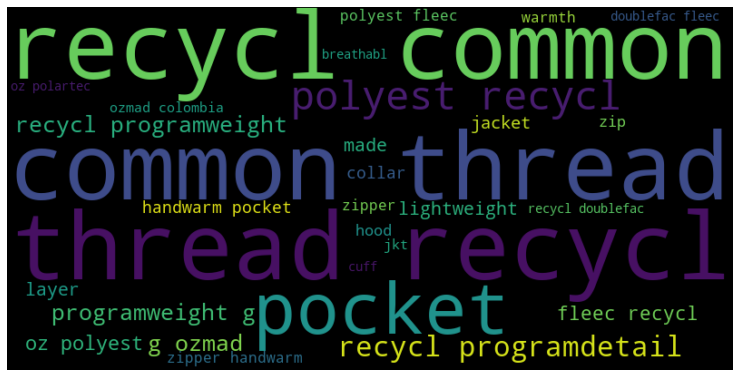




############### Cluster 4 ###############


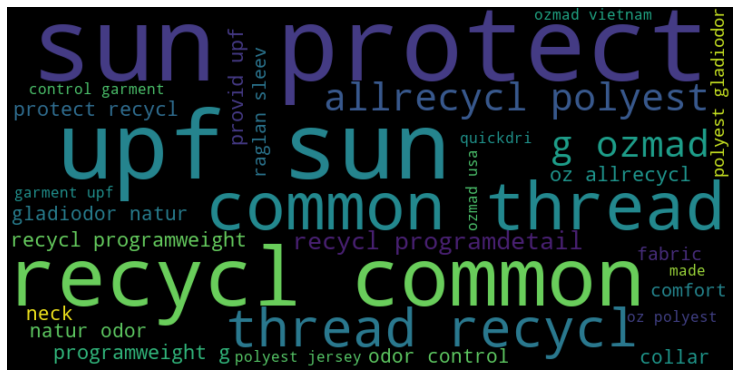




############### Cluster 6 ###############


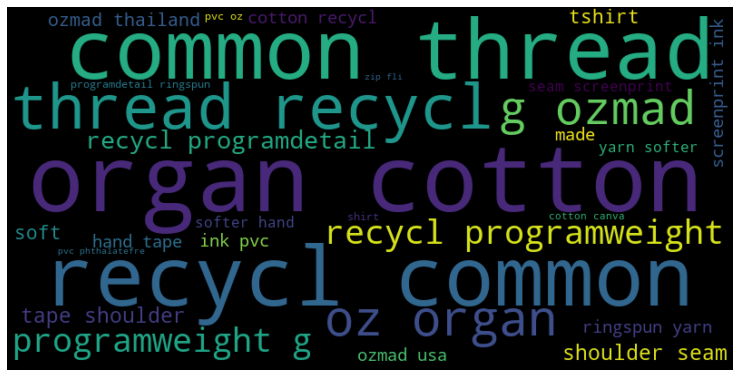




############### Cluster 7 ###############


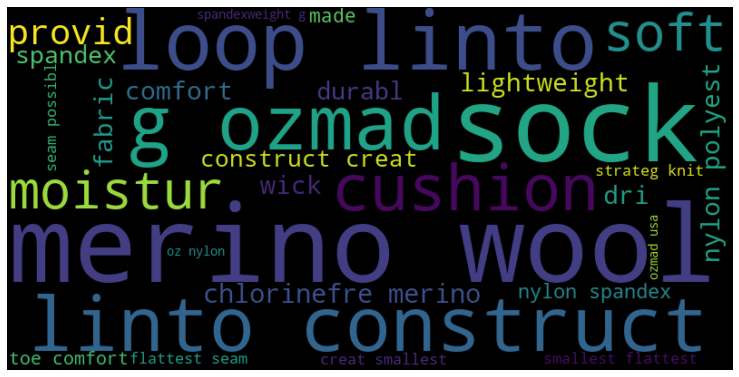

In [12]:
df['cluster'] = model.labels_
df_copy['cluster'] = model.labels_ 
def plot_wordclouds(df=df, to_remove=to_remove):

    to_remove_ = re.compile('('+'|'.join(to_remove)+')')
    unique_clusters = list(df['cluster'].unique())


    for clust in unique_clusters:
        if clust != -1:
    
            to_plot = ' '.join(list(df[df['cluster'] == clust]['description']))
            to_plot = re.sub(pattern=to_remove_ , repl='' , string=to_plot)
    

            wc = WordCloud(width=800, height=400, max_words=30, background_color='black', stopwords=STOPWORDS).generate(to_plot)

            print(f'############### Cluster {clust} ###############')
            plt.figure(figsize=(13,12))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()

            print('\n\n')

plot_wordclouds()

## Analysis of the clusters

In [13]:
def get_top_words_by_cluster(df=df , n=8):
    clusters = list(df['cluster'].unique())

    to_return = {}
    for clust in clusters:
        if clust != -1:
            subset = ' '.join(list(df[df['cluster'] == clust]['description'])).split()
            subset = [word for word in subset if len(word) > 2]
            count_ = Counter(subset)
            to_return[clust] = count_.most_common(n)

    return to_return


top_words = get_top_words_by_cluster()

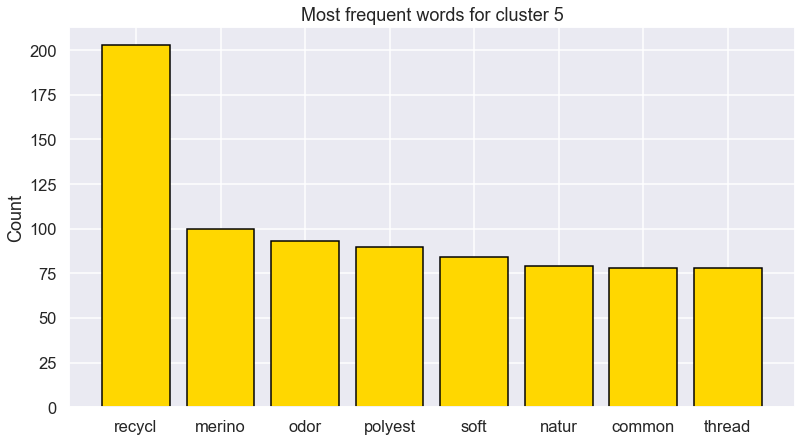

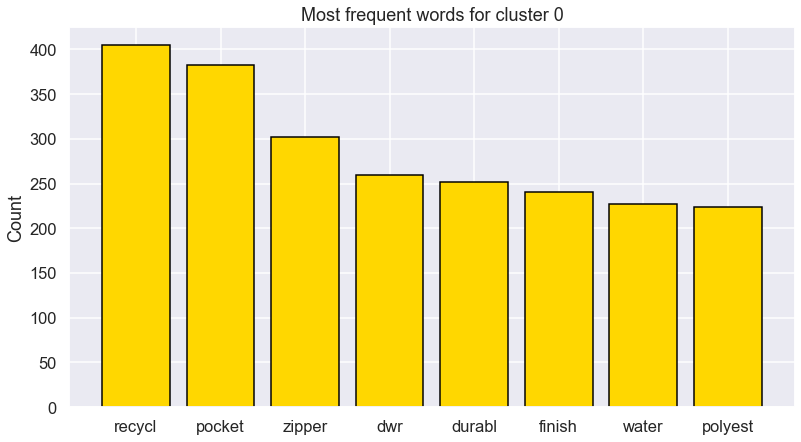

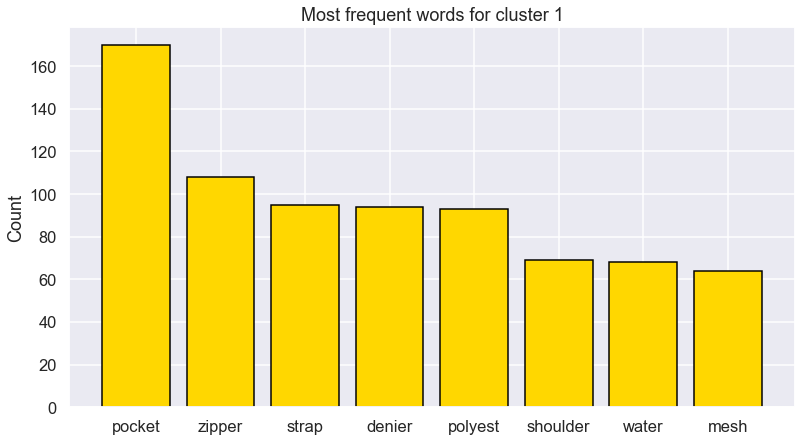

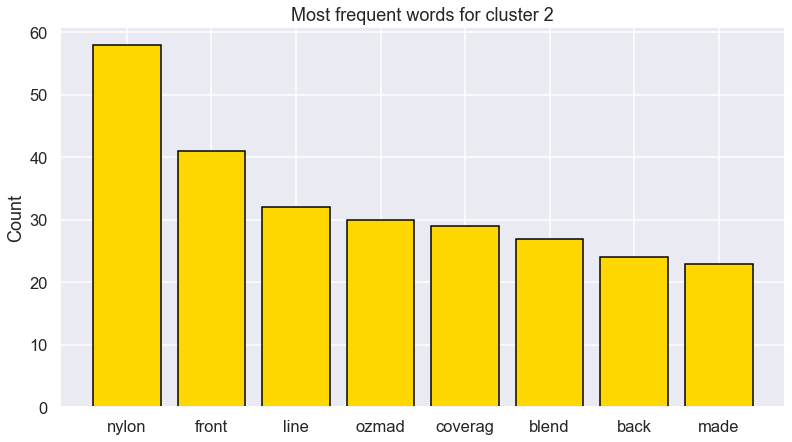

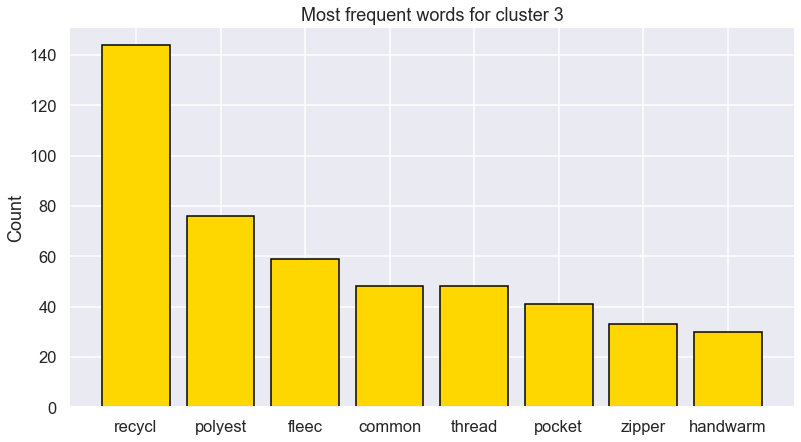

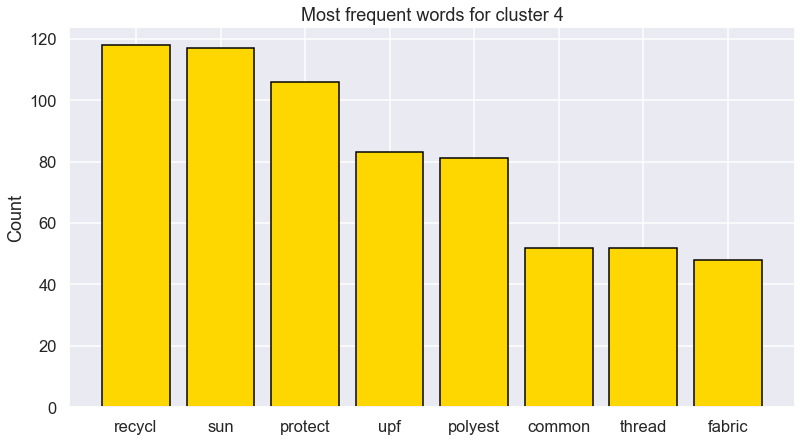

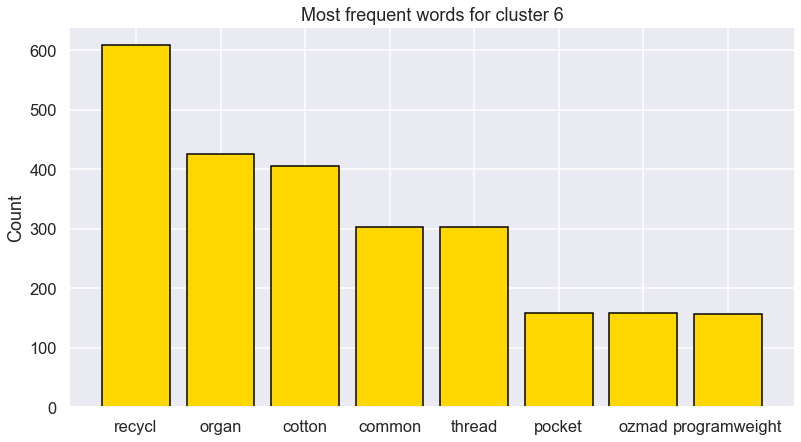

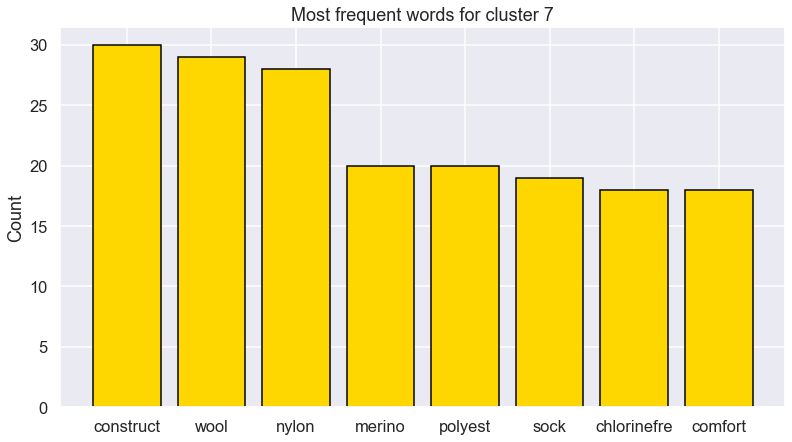

In [14]:
# DWR  =  Durable Water Repellency
def plot_top_words(top_words=top_words):
    for clust in list(df.cluster.unique()):
        if clust != -1:
            words = [word[0] for word in  top_words[clust]]
            n = [n[1] for n in top_words[clust]]

            plt.figure(figsize=(13,7))
            plt.bar(words , n , color='gold' , edgecolor='black')
            plt.title(f'Most frequent words for cluster {clust}')
            plt.ylabel('Count')
            plt.show()


plot_top_words()

In [15]:
# Print the first description per cluster
remove_html = re.compile('<.*?>')
for clust in df.cluster.unique():
    if clust != -1:
        print(f'--------------- Cluster {clust} ---------------')
        print(re.sub(string=df_copy[df_copy['cluster'] == clust].reset_index(drop=True).iloc[0]['description'] , repl='' , pattern=remove_html))
        print(re.sub(string=df_copy[df_copy['cluster'] == clust].reset_index(drop=True).iloc[1]['description'] , repl='' , pattern=remove_html))
        print(re.sub(string=df_copy[df_copy['cluster'] == clust].reset_index(drop=True).iloc[2]['description'] , repl='' , pattern=remove_html) , '\n')

--------------- Cluster 5 ---------------
Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.Details: "Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry" "Exposed, brushed elastic waistband for comfort" 5-panel construction with traditional boxer back "Inseam (size M) is 4 1/2"""Fabric: 3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling ProgramWeight: 99 g (3.5 oz)Made in Mexico.
Cap 1 boxer briefs - On bivy or belay, t

## What can we expect to find in the clusters ?
- Cluster 5 :  merino clothes / casual
- Cluster 0 : water proof / technical clothes
- Cluster 1 : bag / polyest / pocket
- Cluster 2 : Women stuff
- Cluster 3 : Cardigan / sweater / Jacket cosy
- Cluster 4 : Sun protect
- Cluster 6 : Cargo / shorts / coton clothes 
- Cluster 7 : Socks

### Part 2 - Recommender system


In [16]:
def find_similar_items(df_copy=df_copy):
    
    input_ = int(input('Enter the item id you are interested in : '))
    if input_ not in df_copy.index:
        return f'Item not in the data. Please enter a number between {min(df_copy.index)} and {max(df_copy.index)}.'
    else:
        cluster = df_copy.iloc[input_]['cluster']
        sample_ = df_copy[df_copy['cluster'] == cluster].sample(n=5)
        print('List of five items you might also like : ')
        return list(sample_['description'])
    

find_similar_items()

List of five items you might also like : 


["Remat - One man's trash is another man or woman's wader changing mat. The ultimate recycled product, the Remat is a byproduct from automobile gasket manufacturing, reworked and repurposed for a long life of heavy-duty use. Beyond wader changing, it doubles (or triples) as a driftboat seat cushion, work station floor mat or boat floor cleat protection. The tough, cushy, water- and stain-resistant Remat is also showing up in front of kitchen sinks and mudroom doors wherever anglers live. Made from 100% synthetic nitrile rubber.<br><br><b>Details:</b><ul> <li>Withstands temperatures from -40 C to +125 C; Oil/fuel resistant</li> <li>No off-gasing; abrasion resistant</li> <li>Water-resistant; extremely flexible and lightweight</li> <li>No PVC content</li> <li>Floats</li> <li>Recyclable</li> <li>Easy to wash</li></ul><br><br><b>Fabric: </b>100% synthetic rubber. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(461 g 16 oz)<br><br>Made in USA.",
 'Stretch wadin

### Part 3 : Topic modeling with TruncatedSVD

In [17]:
lsa = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=150, random_state=42)
lsa.fit(ml_df)

# Display the subjects
terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    topic_terms = " ".join([terms[j] for j in comp.argsort()[:-8:-1] if terms[j] != 'phthalatefreefabr'])
    print(f"Subjet {i}: {topic_terms}")

Subjet 0: pvc perform one cotton common thailand
Subjet 1: cotton one includ style repel top protect
Subjet 2: nylon moistur control stretch water dri
Subjet 3: wont includ dwr style repel protect shirt
Subjet 4: nexttoskin front two blend stretch pocket lightweight
Subjet 5: stretch tshirt programdetail ink shell wide pvc
Subjet 6: stretch programdetail tshirt one spandex secur size
Subjet 7: spandex perform shirt organ denier nylon make
Subjet 8: front lightweight pocket hip two pvc perform
Subjet 9: allrecycl construct comfort blend soft perform
